# Pneumonia Detection - Model Building



Dataset Link: https://www.kaggle.com/nih-chest-xrays/data

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from random import sample 
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import binarize
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50 
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

### Preprocessing Data:

In [3]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('F:/Chest Xrays/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('F:/Chest Xrays/','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.head()

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,F:/Chest Xrays\images_001\images\00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,F:/Chest Xrays\images_001\images\00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,F:/Chest Xrays\images_001\images\00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,F:/Chest Xrays\images_001\images\00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,F:/Chest Xrays\images_001\images\00000003_000.png


In [4]:
len(all_xray_df.columns)

13

In [5]:
## Create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

df = all_xray_df.copy()

all_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for c_label in all_labels:
    class_label = c_label + "_class"
    if len(c_label)>1: # leave out empty labels
        df[class_label.lower()] = df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
df.head()

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,emphysema_class,fibrosis_class,hernia_class,infiltration_class,mass_class,no finding_class,nodule_class,pleural_thickening_class,pneumonia_class,pneumothorax_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0


In [6]:
len(df)

112120

In [7]:
df['pneumonia_class']

0         0
1         0
2         0
3         0
4         0
         ..
112115    1
112116    0
112117    0
112118    0
112119    0
Name: pneumonia_class, Length: 112120, dtype: int64

In [8]:
def create_splits(df, test_size, target_column):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    
    train_data, val_data = train_test_split(df, 
                                   test_size = test_size, 
                                   stratify = df[target_column])
    
    return train_data, val_data

In [9]:
train_df, val_df = create_splits(df, 0.2, 'pneumonia_class')
print('train_df.shape:', train_df.shape)
print('val_df.shape:', val_df.shape)

train_df.shape: (89696, 28)
val_df.shape: (22424, 28)


In [10]:
train_df['pneumonia_class'].sum()/len(train_df)

0.012765340706386016

In [11]:
val_df['pneumonia_class'].sum()/len(val_df)

0.012754191937210132

In [12]:
# Balancing training set
p_inds = train_df[train_df.pneumonia_class==1].index.tolist()
np_inds = train_df[train_df.pneumonia_class==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]

In [13]:
len(p_inds), len(np_inds), len(np_sample), len(train_df)

(1145, 88551, 1145, 2290)

In [14]:
# Balance train set
train_df['pneumonia_class'].sum()/len(train_df)

0.5

In [15]:
train_df.shape

(2290, 28)

In [16]:
# Balancing validation set
p_inds = val_df[val_df.pneumonia_class==1].index.tolist()
np_inds = val_df[val_df.pneumonia_class==0].index.tolist()

np_sample = sample(np_inds,4*len(p_inds))
val_df = val_df.loc[p_inds + np_sample]

In [17]:
# Balance val set
val_df['pneumonia_class'].sum()/len(val_df)

0.2

In [18]:
val_df.shape

(1430, 28)

In [19]:
train_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,emphysema_class,fibrosis_class,hernia_class,infiltration_class,mass_class,no finding_class,nodule_class,pleural_thickening_class,pneumonia_class,pneumothorax_class
64697,00015968_000.png,Pneumonia,0,15968,36,F,PA,2730,2545,0.143,...,0,0,0,0,0,0,0,0,1,0
23279,00006162_008.png,Infiltration|Pneumonia,8,6162,78,M,AP,2500,2048,0.171,...,0,0,0,1,0,0,0,0,1,0
2295,00000591_004.png,Effusion|Infiltration|Pleural_Thickening|Pneum...,4,591,63,M,PA,2500,2048,0.168,...,0,0,0,1,0,0,0,1,1,0
109491,00029801_002.png,Infiltration|Pneumonia,2,29801,24,F,AP,3056,2544,0.139,...,0,0,0,1,0,0,0,0,1,0
77401,00019018_003.png,Edema|Infiltration|Pneumonia,3,19018,28,M,AP,3056,2544,0.139,...,0,0,0,1,0,0,0,0,1,0


In [20]:
val_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,emphysema_class,fibrosis_class,hernia_class,infiltration_class,mass_class,no finding_class,nodule_class,pleural_thickening_class,pneumonia_class,pneumothorax_class
4875,00001301_039.png,Edema|Effusion|Pneumonia,39,1301,57,F,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,1,0
10967,00002846_013.png,Consolidation|Effusion|Infiltration|Pneumonia,13,2846,34,M,PA,2892,2967,0.143,...,0,0,0,1,0,0,0,0,1,0
20868,00005567_016.png,Emphysema|Pneumonia,16,5567,49,M,PA,2770,2557,0.143,...,1,0,0,0,0,0,0,0,1,0
53150,00013411_002.png,Effusion|Infiltration|Pneumonia,2,13411,22,M,AP,2500,2048,0.168,...,0,0,0,1,0,0,0,0,1,0
10135,00002633_016.png,Atelectasis|Effusion|Pneumonia,16,2633,44,F,PA,2870,2693,0.143,...,0,0,0,0,0,0,0,0,1,0


In [21]:
### Since Training and Validation are approx equal. (50-50 split)
### Removing 30% of data from validation and adding it to training set, so that split is around (70:30) for training and validation set

In [22]:
tdf2 = val_df.sample(frac =0.3)

In [23]:
tdf2.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,emphysema_class,fibrosis_class,hernia_class,infiltration_class,mass_class,no finding_class,nodule_class,pleural_thickening_class,pneumonia_class,pneumothorax_class
35477,00009354_001.png,Consolidation|Fibrosis,1,9354,55,M,PA,2500,2048,0.168,...,0,1,0,0,0,0,0,0,0,0
10161,00002638_000.png,No Finding,0,2638,40,F,PA,2544,3056,0.139,...,0,0,0,0,0,1,0,0,0,0
103194,00027505_000.png,No Finding,0,27505,68,M,PA,2506,2991,0.143,...,0,0,0,0,0,1,0,0,0,0
17138,00004595_004.png,No Finding,4,4595,16,F,PA,2048,2500,0.168,...,0,0,0,0,0,1,0,0,0,0
87025,00021478_000.png,Infiltration,0,21478,67,M,PA,2992,2991,0.143,...,0,0,0,1,0,0,0,0,0,0


In [24]:
len(tdf2), len(val_df)

(429, 1430)

In [25]:
tdf2_list = tdf2.index.to_list()
tdf2_list[0:5], len(tdf2_list)

([35477, 10161, 103194, 17138, 87025], 429)

In [26]:
val_df2 = val_df
len(val_df2)

1430

In [27]:
val_df2.drop(tdf2_list, inplace = True )

In [28]:
len(val_df2)

1001

In [29]:
training_df = pd.concat([train_df, tdf2], axis=0)
training_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,emphysema_class,fibrosis_class,hernia_class,infiltration_class,mass_class,no finding_class,nodule_class,pleural_thickening_class,pneumonia_class,pneumothorax_class
64697,00015968_000.png,Pneumonia,0,15968,36,F,PA,2730,2545,0.143,...,0,0,0,0,0,0,0,0,1,0
23279,00006162_008.png,Infiltration|Pneumonia,8,6162,78,M,AP,2500,2048,0.171,...,0,0,0,1,0,0,0,0,1,0
2295,00000591_004.png,Effusion|Infiltration|Pleural_Thickening|Pneum...,4,591,63,M,PA,2500,2048,0.168,...,0,0,0,1,0,0,0,1,1,0
109491,00029801_002.png,Infiltration|Pneumonia,2,29801,24,F,AP,3056,2544,0.139,...,0,0,0,1,0,0,0,0,1,0
77401,00019018_003.png,Edema|Infiltration|Pneumonia,3,19018,28,M,AP,3056,2544,0.139,...,0,0,0,1,0,0,0,0,1,0


In [30]:
len(training_df)

2719

In [31]:
validation_df = val_df2
len(validation_df)

1001

In [32]:
training_df['pneumonia_class'].value_counts()

0    1487
1    1232
Name: pneumonia_class, dtype: int64

In [33]:
val_df2['pneumonia_class'].value_counts()

0    802
1    199
Name: pneumonia_class, dtype: int64

## Model-building & training

### Augumenting data

In [34]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    # Todo
    my_idg = ImageDataGenerator(rescale = 1 / 255.,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   height_shift_range=0.1,
                                   width_shift_range=0.1,
                                   rotation_range=20,
                                   shear_range=0.15,
                                   zoom_range=0.12)
    
    return my_idg


def make_train_gen(target_size, batch_size):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    my_train_idg = my_image_augmentation()
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = "path",
                                         y_col = 'pneumonia_class',
                                         class_mode = 'raw',
                                         target_size = target_size, 
                                         batch_size = batch_size
                                         )

    return train_gen


def make_val_gen(target_size, batch_size):
    
    my_val_idg = ImageDataGenerator(rescale=1. / 255.0)
    val_gen = my_val_idg.flow_from_dataframe(dataframe=val_df, 
                                             directory=None, 
                                             shuffle = False,
                                             x_col = "path",
                                             y_col = 'pneumonia_class',
                                             class_mode = 'raw',
                                             target_size = target_size, 
                                             batch_size = batch_size
                                             )
    
    return val_gen

In [60]:
batch_size = 28
target_size = (224, 224)

train_gen = make_train_gen(target_size, batch_size)
val_gen = make_val_gen(target_size, batch_size)

Found 2290 validated image filenames.
Found 1001 validated image filenames.


In [61]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

In [62]:
valX.shape, valY.shape

((28, 224, 224, 3), (28,))

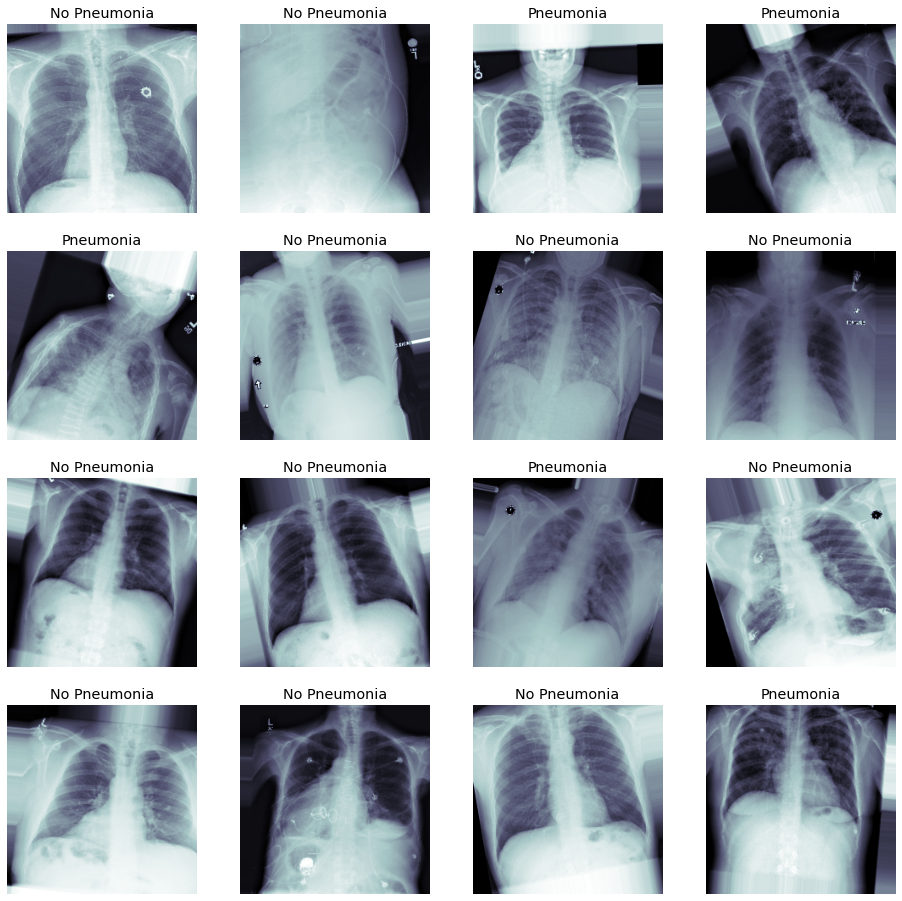

In [63]:
## Looking at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Building base model

In [64]:
### Based on VGG16 Model

In [65]:
from tensorflow.keras.layers import Input, Conv2D 
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense 
from tensorflow.keras import Model

In [94]:
tf.keras.backend.clear_session()

In [95]:
def load_pretrained_model():
    
#     model = ResNet50(include_top=False, weights='imagenet')
# #     transfer_layer = model.get_layer('conv5_block3_out')
#     new_model = Model(inputs = model.input, outputs = model.output)
    
#     for layer in new_model.layers[:-10]:
#         layer.trainable = False
    
    model = VGG16(include_top=False, weights='imagenet', input_shape = (224, 224, 3))
        
    return model
#     return new_model


In [96]:
def build_model():
    # VGG ARCH

#     input = tf.keras.layers.Input(shape =(512,512,3))
#     # 1st Conv Block

#     x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(input)
#     x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
#     x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
#     # 2nd Conv Block

#     x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
#     x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
#     x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
#     # 3rd Conv block

#     x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
#     x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
#     x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
#     x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
#     # 4th Conv block

#     x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
#     x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
#     x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
#     x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

#     # 5th Conv block

#     x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
#     x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
#     x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
#     x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)


    # Fully connected layers
    vgg_model = load_pretrained_model()
#     for layer in vgg_model.layers[:17]:
#         layer.trainable = False
    vgg_model.trainable = False
    pd_model = Sequential([
        vgg_model,
        #GlobalAveragePooling2D(),
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    return pd_model

In [97]:
my_model = build_model()
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                        

In [98]:
## Below helper code will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training

In [99]:
## train your model

my_model.compile(optimizer=Adam(learning_rate=2e-4), loss='binary_crossentropy', metrics=['accuracy'])
history = my_model.fit(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 10, 
                          callbacks = callbacks_list)

Epoch 1/10
82/82 [==============================] - ETA: 0s - loss: 0.8500 - accuracy: 0.5568
Epoch 00001: val_loss improved from inf to 0.44918, saving model to xray_class_my_model.best.hdf5
82/82 [==============================] - 47s 554ms/step - loss: 0.8500 - accuracy: 0.5568 - val_loss: 0.4492 - val_accuracy: 0.9643
Epoch 2/10
82/82 [==============================] - ETA: 0s - loss: 0.7741 - accuracy: 0.5694
Epoch 00002: val_loss improved from 0.44918 to 0.41164, saving model to xray_class_my_model.best.hdf5
82/82 [==============================] - 45s 545ms/step - loss: 0.7741 - accuracy: 0.5694 - val_loss: 0.4116 - val_accuracy: 0.8571
Epoch 3/10
82/82 [==============================] - ETA: 0s - loss: 0.7599 - accuracy: 0.5686
Epoch 00003: val_loss did not improve from 0.41164
82/82 [==============================] - 46s 563ms/step - loss: 0.7599 - accuracy: 0.5686 - val_loss: 0.4393 - val_accuracy: 0.8571
Epoch 4/10
82/82 [==============================] - ETA: 0s - loss: 0.7

In [100]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
val_Y = val_df['pneumonia_class']
pred_Y = my_model.predict(val_gen, verbose = True)
# val_Y = valY
# pred_Y = my_model.predict(valX, batch_size = 64, verbose = True)


36/36 [==============================] - 11s 303ms/step


In [101]:
my_model.evaluate(valX, valY)

1/1 [==============================] - 0s 120ms/step - loss: 0.5476 - accuracy: 0.7857


[0.5476388335227966, 0.7857142686843872]

In [102]:
#Loading best saved weights
my_model.load_weights('xray_class_my_model.best.hdf5')

In [114]:
# Saving best weights model
my_model.save('puenomia_detection_va92_vl26.h5')

In [115]:
my_model.evaluate(valX, valY)

1/1 [==============================] - 1s 569ms/step - loss: 0.3454 - accuracy: 0.8929


[0.3454115092754364, 0.8928571343421936]

In [116]:
def plot_auc(t_y, p_y):
    
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
    return

## what other performance statistics do you want to include here besides AUC? 


def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    
#Also consider plotting the history of your model training:

def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize = (12, 5))
    axs = axs.flatten()
    plt.style.use("ggplot")
    N = len(history.history["loss"])
    
    axs[0].plot(np.arange(N), history.history["loss"], label = 'train_loss')
    axs[0].plot(np.arange(N), history.history["val_loss"], label = 'val_loss')
    axs[0].set_xlabel('# epochs')
    axs[0].set_ylabel('loss')
    axs[0].set_title('Loss curve')
    axs[0].legend()
    
    axs[1].plot(np.arange(N), history.history["accuracy"], label = 'train_binary_accuracy')
    axs[1].plot(np.arange(N), history.history["val_accuracy"], label = 'val_binary_accuracy')
    axs[1].set_xlabel('# epochs')
    axs[1].set_ylabel('accuracy')
    axs[1].set_title('Accuracy curve')
    axs[1].legend()
    return

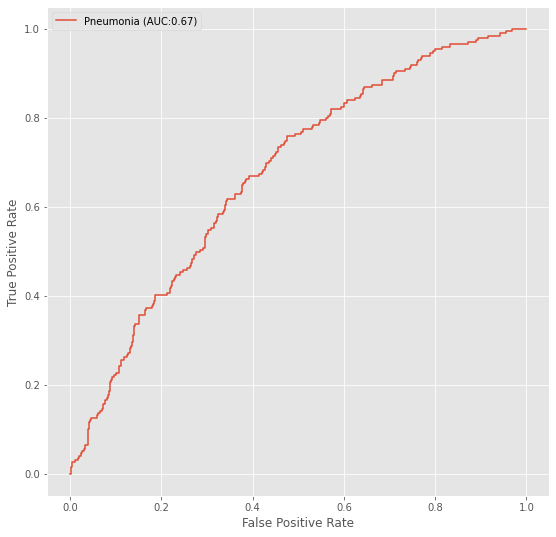

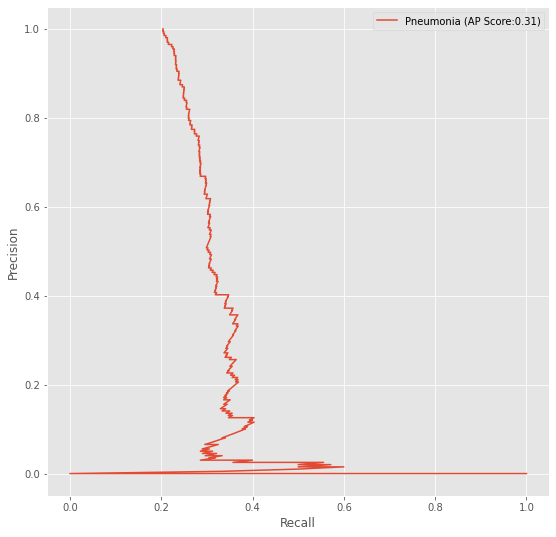

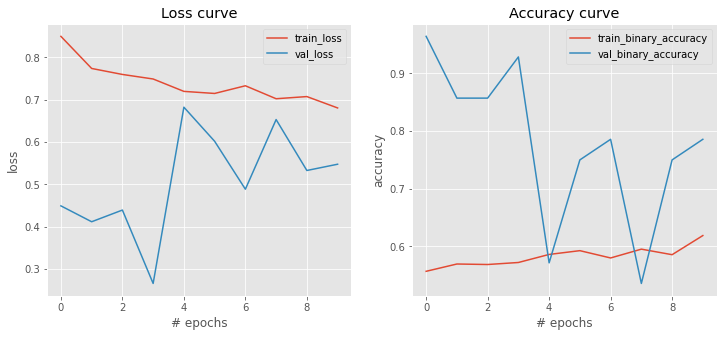

In [117]:
## plot figures

plot_auc(val_Y, pred_Y)
plot_pr(val_Y, pred_Y)
plot_history(history)

In [118]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall) if recall and prec else 0

precision, recall, thresholds = precision_recall_curve(val_Y, pred_Y)
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]
idx = np.argmax(f1score)
print('Precision: '+ str(precision[idx]))
print('Recall: '+ str(recall[idx]))
print('Threshold: '+ str(thresholds[idx]))
print('F1 Score: ' + str(f1score[idx]))

Precision: 0.28330206378986866
Recall: 0.7587939698492462
Threshold: 0.48845482
F1 Score: 0.41256830601092886


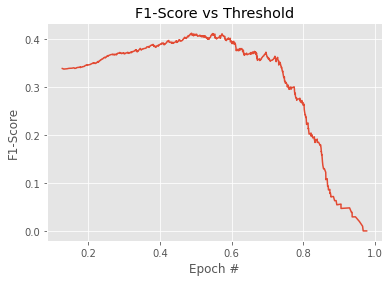

In [119]:
plt.figure()
plt.plot(thresholds, f1score)
plt.title("F1-Score vs Threshold")
plt.xlabel("Epoch #")
plt.ylabel("F1-Score")
plt.show()

In [120]:
YOUR_THRESHOLD = thresholds[idx]

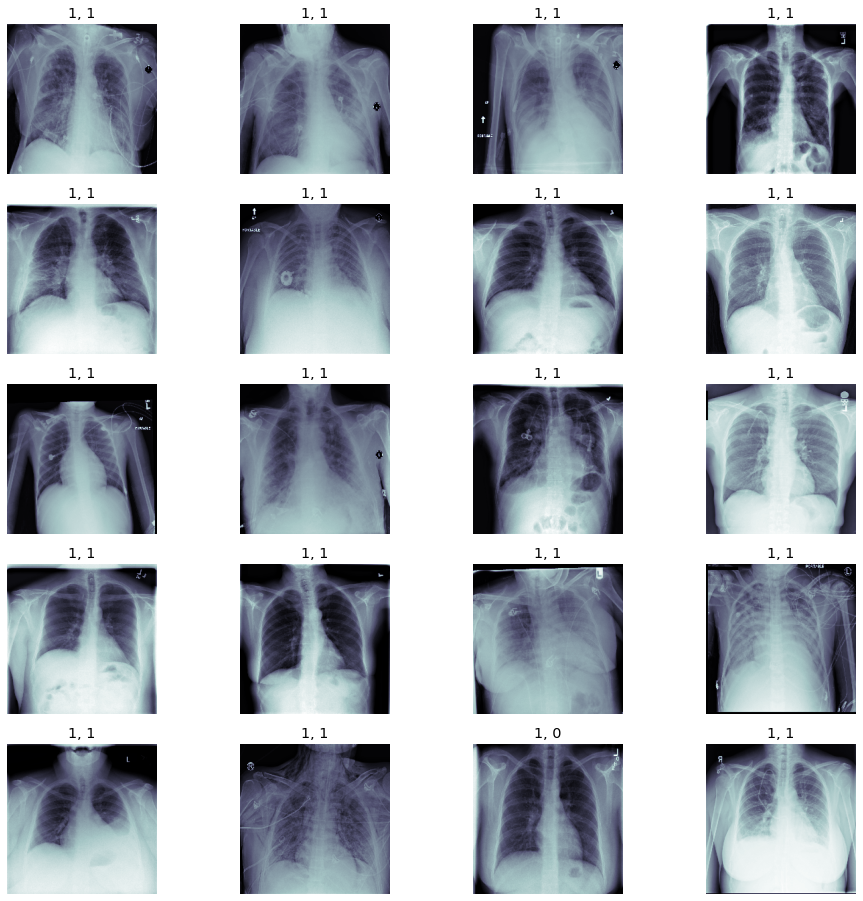

In [121]:
## Let's look at some examples of true vs. predicted with our best model: 

valX, valY = val_gen.next()
predY = my_model.predict(valX)
predY = predY.reshape(-1)

fig, m_axs = plt.subplots(5, 4, figsize = (16, 16))
i = 0

for (c_x, c_y, c_ax) in zip(valX[0:64], valY[0:64], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if predY[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if predY[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [111]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model_final_best_ck.json", "w") as json_file:
    json_file.write(model_json)

### Comparing Best Saved Weights model and Complete Trained Model

In [112]:
m1 = tf.keras.models.load_model('final_best_ck_puenomia_detection_vl_0285_va_09286.h5')

In [3]:
m2 = tf.keras.models.load_model('final_best_ck_puenomia_detection_vl_03166_va_08214.h5')

In [108]:
m1.evaluate(valX, valY), m2.evaluate(valX, valY)

1/1 [==============================] - 0s 278ms/step - loss: 0.4509 - accuracy: 0.8214


([0.28528881072998047, 0.9285714030265808],
 [0.45091989636421204, 0.8214285969734192])

In [111]:
## For m1
pred_Y = m1.predict(val_gen, verbose = True)
precision, recall, thresholds = precision_recall_curve(val_Y, pred_Y)
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]
idx = np.argmax(f1score)
print('Precision: '+ str(precision[idx]))
print('Recall: '+ str(recall[idx]))
print('Threshold: '+ str(thresholds[idx]))
print('F1 Score: ' + str(f1score[idx]))

36/36 [==============================] - 12s 339ms/step
Precision: 0.30904522613065327
Recall: 0.6029411764705882
Threshold: 0.80008316
F1 Score: 0.40863787375415284


In [112]:
# For m2
pred_Y = m2.predict(val_gen, verbose = True)
precision, recall, thresholds = precision_recall_curve(val_Y, pred_Y)
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]
idx = np.argmax(f1score)
print('Precision: '+ str(precision[idx]))
print('Recall: '+ str(recall[idx]))
print('Threshold: '+ str(thresholds[idx]))
print('F1 Score: ' + str(f1score[idx]))

36/36 [==============================] - 12s 334ms/step
Precision: 0.2748091603053435
Recall: 0.7058823529411765
Threshold: 0.58776367
F1 Score: 0.3956043956043956
